In [30]:
import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import optax 
from jax import vmap
import jax_dataloader as jdl
from dataclasses import dataclass
import optuna
import matplotlib.pyplot as plt
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)

import sys
sys.path.append("..")
from networks import *
from utils import *

In [31]:
JAX_LOG_COMPILES = 1

In [32]:
from networks import _self_adaptive

sa_hparams = _self_adaptive.SAHparams()

# Load data

In [44]:
data = jnp.load("../data/advection.npz")
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1
NUMBER_OF_SENSORS = M+1
PATH = r"C:\Users\eirik\orbax"

# Normalize data

In [51]:
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Define loss function

In [52]:
def compute_loss(model, a, u, key):
    """Computes the loss of the model.
    """
    u_shape = u.shape
    batch_size = u_shape[0]
    N = u_shape[1]-1
    M = u_shape[2]-1
    num_points = 25
    
    x_key, t_key = random.split(key)
    x_keys = random.split(x_key, batch_size)
    t_keys = random.split(t_key, batch_size)
    
    a_rand =  a[:,::4] #vmap(lambda key, row: jnp.sort(random.choice(key, row, shape=(num_points,), replace=True)))(x_keys, a)
    x_rand = x[::4] #vmap(lambda key: jnp.sort(random.choice(key, x, shape=(num_points,), replace=True)))(x_keys)
    t_rand = t[::4] #vmap(lambda key: jnp.sort(random.choice(key, t, shape=(num_points,), replace=True)))(t_keys)
    u_rand = u[:,::4, ::4]
    
    u_pred = vmap(model, (0, None, None))(a_rand, x_rand, t_rand)
    
    if model.self_adaptive:
        loss = jnp.mean(jnp.square(u_pred - u_rand)) #MSE
       
    else:
        loss = jnp.mean(jnp.square(u_pred - u_rand))

    return loss

Trainer.compute_loss = staticmethod(compute_loss)

# Define make step function

In [53]:
@eqx.filter_jit
def make_step(model, opt_state, opt, a, u, key):
    """Performs a single optimization step."""

    loss, grads = eqx.filter_value_and_grad(Trainer.compute_loss)(model, a, u, key)
    updates, opt_state = opt.update([grads], opt_state)
    model = eqx.apply_updates(model, updates[0])
    
    if model.self_adaptive:
        # normalize λ
        model = eqx.tree_at(lambda m : m.self_adaptive.λ, model, model.self_adaptive.λ/jnp.mean(model.self_adaptive.λ))        
    
    return model, opt_state, loss

Trainer.make_step = staticmethod(make_step)

In [54]:
hparams = fno2d.Hparams(n_blocks=3, hidden_dim=25, modes_max=8, λ_learning_rate=1e-2, λ_shape = (N+1, M+1))

model = FNO2d(hparams)

In [55]:

train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax')
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax')

θ_learning_rate = 1e-3
λ_learning_rate = 1e-2

θ_optimizer = optax.adam(θ_learning_rate)
λ_optimizer = optax.chain(optax.adam(λ_learning_rate), optax.scale(-1.))
opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
opt_state = opt.init(eqx.filter([model], eqx.is_array))

trainer = Trainer(model, opt, opt_state, train_loader, val_loader, hparams = hparams, animate=True, max_epochs=30, save_path=PATH)

In [56]:
trainer()

Output()

In [57]:
plot_loss(trainer)

In [41]:

def plot_predictions(u, a, x, t, *models, **kwargs):
    """Displays the predictions and errors of a list of models on a given sample.
    Pressing the button generates the animation for a new sample

    Args:
        u (n_samples, t_dim, x_dim): ground truth solutions
        a (n_samples, x_dim): input to models
        x (x_dim): spatial points
        t (t_dim): time points
    """
    app = dash.Dash(external_stylesheets=[dbc.themes.MATERIA])

    app.layout = dbc.Container(
        [
            html.H1("Predictions and Errors"),
            dbc.Button("New sample",color="primary", id="button"),
            dbc.Tabs(
                [
                    dbc.Tab(label="Predictions", tab_id="predictions"),
                    dbc.Tab(label="Errors", tab_id="errors"),
                    dbc.Tab(label="Both", tab_id="both"),
                ],
                id="tabs",
                active_tab="predictions",
            ),
            dbc.Spinner(
                [
                    dcc.Store(id="store"),
                    html.Div(id="tab-content", className="p-4"),
                ],
                delay_show=100,
            ),
        ]
    )

    @app.callback(
        Output("tab-content", "children"),
        [Input("tabs", "active_tab"), Input("store", "data")],
    )
    def render_tab_content(active_tab, data):
        if active_tab is not None and data:
            if active_tab == "predictions":
                return dcc.Graph(figure=data["Predictions"])
            elif active_tab == "errors":
                return dcc.Graph(figure=data["Errors"])
            elif active_tab == "both":
                return dcc.Graph(figure=data["Both"])
        return "No tab selected"

    @app.callback(
        Output("store", "data"),
        [Input("button", "n_clicks")]
    )
    def generate_graphs(n):
        if not n:
            n = 0
        # Select a new function based on the button click
        a_sample = a[n]
        u_sample = u[n].ravel()

        model_names = kwargs.get("model_names", [f"Model {i}" for i in range(len(models))])

        df = pd.DataFrame({
            "Ground Truth": u_sample,
            "x": jnp.tile(round(x, 2), len(t)),
            "t": jnp.repeat(round(t, 2), len(x))
        })

        prediction_columns = ["Ground Truth"] + model_names
        error_columns = [f"Error {model_name}" for model_name in model_names]

        for i, model in enumerate(models):
            prediction = model(a_sample, x, t).ravel()
            error = jnp.abs(prediction - u_sample)
            df[model_names[i]] = prediction
            df[f"Error {model_names[i]}"] = error
            
        y_min = df[prediction_columns].min().min()
        y_max = df[prediction_columns].max().max()

        animations = {
            "Predictions": px.line(df, x='x', y=prediction_columns, animation_frame='t', range_y=[y_min, y_max],
                                   labels={'t': 'Time (t)', 'u': 'u(x, t)'}),
            "Errors": px.line(df, x='x', y=error_columns, animation_frame='t', range_y=[0, df[error_columns].max().max()],
                              labels={'t': 'Time (t)', 'u': 'u(x, t)'}),
            "Both": px.line(df, x='x', y=prediction_columns + error_columns, animation_frame='t', range_y=[y_min, y_max],
                            labels={'t': 'Time (t)', 'u': 'u(x, t)'}),
        }

        for key, fig in animations.items():
            fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
            fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 20
            for data in fig.data:
                if key == "Both":
                    if data.name.startswith("Error"):
                        data.line.dash = 'dash'
                    elif data.name == 'Ground Truth':
                        data.line.dash = 'dot'
                        data.line.color = 'black'
                elif key == "Predictions":
                    if data.name == 'Ground Truth':
                        data.line.dash = 'dot'
                        data.line.color = 'black'

            for frame in fig.frames:
                for data in frame.data:
                    if key == "Both":
                        if data.name.startswith("Error"):
                            data.line.dash = 'dash'
                        elif data.name == 'Ground Truth':
                            data.line.dash = 'dot'
                            data.line.color = 'black'
                    elif key == "Predictions":
                        if data.name == 'Ground Truth':
                            data.line.dash = 'dot'
                            data.line.color = 'black'

        return animations


    app.run_server()


In [44]:
plot_predictions(u_test, a_test, x, t, trainer.model)

# Optuna

In [ ]:
class HyperparameterTuning:
    def __init__(self, key, **kwargs):
        self.key = key
        self.kwargs = kwargs

    def __call__(self, trial):
        
        hparams = ModifiedDeepONetFast.Hparams(
            width=trial.suggest_int("width", 50, 150),
            depth=trial.suggest_int("depth", 3, 10),
            interact_size=trial.suggest_int("interact_size", 5, 25),
            θ_learning_rate=trial.suggest_float("θ_learning_rate", 1e-4, 1e-2),
            batch_size=16,
        )
        
        self_adaptive=trial.suggest_categorical("self_adaptive", [True, False])
        
        θ_optimizer = optax.adam(hparams.θ_learning_rate)
        
        if self_adaptive:
            self_adaptive = SelfAdaptive(shape = (N+1, M+1))
            hparams.λ_learning_rate=trial.suggest_float("λ_learning_rate", 1e-3, 1e-1),
            hparams.λ_mask = trial.suggest_categorical("λ_mask", ["soft-relu", "quadratic", "sigmoid"])
            λ_optimizer = optax.chain(optax.adam(hparams.λ_learning_rate), optax.scale(-1.))
            opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
        else:
            opt = θ_optimizer
        
        # Initialize the model with the random hyperparameters
        model = ModifiedDeepONetFast(hparams, number_of_sensors=NUMBER_OF_SENSORS, N=N, M=M, P=P, key=self.key)
        
        opt_state = opt.init(eqx.filter([model], eqx.is_array))

        train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train, u_train), batch_size=hparams.batch_size, backend='jax', shuffle=True)
        val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val, u_val), batch_size=hparams.batch_size, backend='jax', shuffle=True)

        trainer = Trainer(model, opt, opt_state, train_loader, val_loader, trial=trial, **self.kwargs)
        trainer.train_model()
        last_val_loss = trainer.current_val_loss
        
        return last_val_loss

In [7]:
num_trials = 3

study = optuna.create_study(
    study_name='test',
    storage=f'sqlite:///optuna/optuna_hparam_search.db',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    sampler = optuna.samplers.TPESampler(seed=1),
    load_if_exists=True,
)


with ProgressBar(mode = "trial") as p:
    p.pbar.update(p.trials_id, total = num_trials)
    study.optimize(HyperparameterTuning(random.PRNGKey(0), max_epochs = 100, early_stopping=False), n_trials=num_trials, callbacks = [lambda study, trial: p.pbar.advance(p.trials_id)])


Output()

# Train model for some more epochs

## Code without self-adaptive weights

In [17]:
# Suggested hyperparameters

hparams = ModifiedDeepONetFastHparams(
    **study.best_params,
    batch_size=16,
)

# Create model instance

opt = optax.adam(hparams.θ_learning_rate)

# Initialize the model with the random hyperparameters
model = ModifiedDeepONetFast(
    hparams, 
    number_of_sensors=NUMBER_OF_SENSORS, 
    P=P, 
    M=M, 
    N=N, 
    key=random.PRNGKey(0)
)

opt_state = opt.init(eqx.filter([model], eqx.is_array))

train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train, u_train), batch_size=hparams.batch_size, backend='jax', shuffle=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val, u_val), batch_size=hparams.batch_size, backend='jax', shuffle=True)

trainer = Trainer(model, opt, opt_state, train_loader, val_loader, early_stopping=False, max_epochs=100, hparams=hparams)
trainer.train_model()

Output()

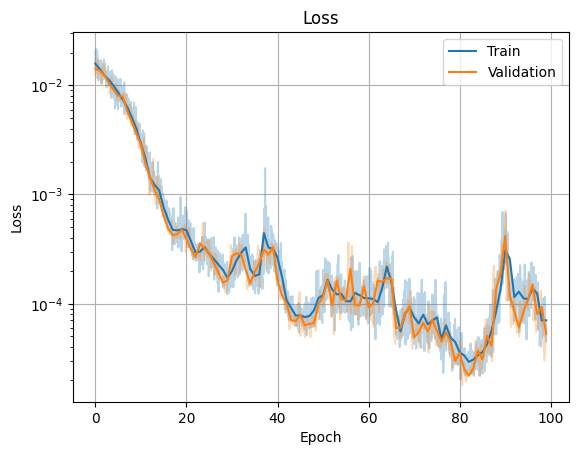

In [ ]:
trainer.plot_loss()

In [ ]:
# Suggested hyperparameters

hparams_sa = ModifiedDeepONetFastHparams(
    **study.best_params,
    self_adaptive=True,
    λ_mask = "soft-relu",
    λ_learning_rate = 5e-2,
    batch_size=16,
)

# Create model instance

θ_optimizer = optax.adam(hparams_sa.θ_learning_rate)
λ_optimizer = optax.chain(optax.adam(hparams_sa.λ_learning_rate), optax.scale(-1.))
opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)

# Initialize the model with the random hyperparameters
model_sa = ModifiedDeepONetFast(
    hparams_sa, 
    number_of_sensors=NUMBER_OF_SENSORS, 
    P=P, 
    M=M, 
    N=N, 
    key=random.PRNGKey(0)
)

opt_state = opt.init(eqx.filter([model_sa], eqx.is_array))

train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train, u_train), batch_size=hparams.batch_size, backend='jax', shuffle=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val, u_val), batch_size=hparams.batch_size, backend='jax', shuffle=True)

trainer_sa = Trainer(model_sa, opt, opt_state, train_loader, val_loader, early_stopping=False, max_epochs=100, hparams=hparams_sa, filename="model_sa", animate=True)
trainer_sa.train_model()

Output()

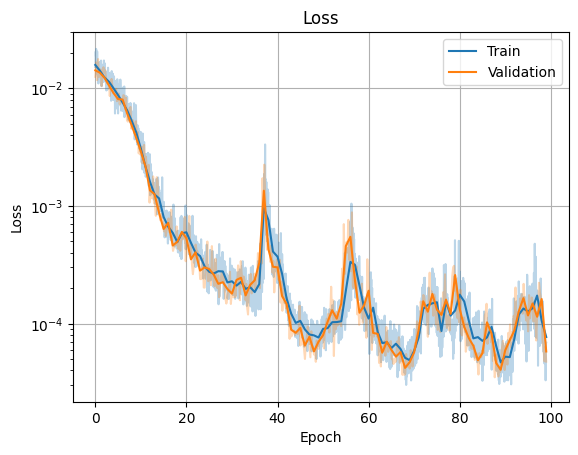

In [ ]:
trainer_sa.plot_loss()

In [8]:
model = load_model(ModifiedDeepONetFast, ModifiedDeepONetFastHparams, "model")
model_sa = load_model(ModifiedDeepONetFast, ModifiedDeepONetFastHparams, "model_sa")

TypeError: ModifiedDeepONetFastHparams.__init__() got an unexpected keyword argument 'n_blocks'

In [19]:
display_predictions(u_test, a_test, x, t, trainer.model, model_names = ["Operator learning model"])

In [ ]:
display_self_adaptive_weights(trainer_sa)

[2024-11-07 14:45:56,106] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^